# Importation des modules

In [1]:
import pandas as pd
import load_data as ld
import preprocessing as pp
import plot_eval_opti as peo
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectFromModel
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Chargement des données

In [26]:
# Pour la reproductibilité des résultats
random_state: int = 0

# Nombre de matchs précédents à considérer
n_shift: int = 20

In [27]:
# Préparation du dataset
data = ld.calculate_previous_results(data=ld.load_dataset("./games.csv"), n_shift=n_shift)
display(data)

,Date,Home Team,Away Team,season,pts_h,fg_h,ft_h,fg3_h,ast_h,reb_h,...,Home_pts_1,Home_astM_1,Home_fgM_1,Home_fg3M_1,Home_def_1,Home_astG_1,Home_fgG_1,Home_fg3G_1,Home_reb_1,Home_wr_1
0,2003-12-06,1610612739,1610612737,2003,95.0,0.467,0.793,0.250,22.0,42.0,...,83.0,21.0,0.438,0.250,80.0,18.0,0.350,0.429,0.0,1.0
1,2003-12-06,1610612748,1610612759,2003,70.0,0.388,0.600,0.200,11.0,39.0,...,86.0,15.0,0.352,0.222,79.0,7.0,0.329,0.143,11.0,1.0
2,2003-12-06,1610612745,1610612765,2003,86.0,0.463,0.533,0.308,20.0,47.0,...,80.0,10.0,0.470,0.333,104.0,22.0,0.527,0.429,4.0,0.0
3,2003-12-06,1610612742,1610612753,2003,110.0,0.523,0.682,0.357,21.0,55.0,...,99.0,20.0,0.488,0.167,89.0,15.0,0.408,0.350,18.0,1.0
4,2003-12-06,1610612749,1610612764,2003,109.0,0.414,0.689,0.375,24.0,49.0,...,94.0,20.0,0.427,0.154,105.0,25.0,0.494,0.267,-5.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19051,2021-07-08,1610612756,1610612749,2020,118.0,0.489,0.857,0.500,26.0,43.0,...,118.0,22.0,0.466,0.406,117.0,23.0,0.543,0.455,9.0,1.0
19052,2021-07-11,1610612749,1610612756,2020,120.0,0.478,0.769,0.389,28.0,47.0,...,112.0,14.0,0.422,0.324,118.0,23.0,0.517,0.438,-4.0,0.0
19053,2021-07-14,1610612749,1610612756,2020,109.0,0.402,0.828,0.241,22.0,48.0,...,109.0,19.0,0.438,0.161,107.0,22.0,0.364,0.400,13.0,1.0
19054,2021-07-17,1610612756,1610612749,2020,119.0,0.552,0.909,0.684,23.0,35.0,...,99.0,24.0,0.465,0.321,90.0,19.0,0.434,0.269,14.0,1.0


In [70]:
# Backup des données
data.to_csv("dataset_shifted.csv", index=False)

# Data Engineering + Data Cleaning + Visualisation

In [28]:
# Calculer des statistiques globales avec les matchs précédents
features, target = ld.calculate_team_statistics(data=data.iloc[:, 19:]), data.loc[:, "result"]
display(features)
display(target)

,Home_pts_mode,Home_pts_mean,Home_pts_std,Home_pts_var,Home_pts_q25,Home_pts_q75,Home_pts_iqr,Home_pts_median,Home_pts_min,Home_pts_max,...,Away_reb_iqr,Away_reb_median,Away_reb_min,Away_reb_max,Away_reb_skw,Away_reb_kur,Away_wr_mode,Away_wr_mean,Away_wr_std,Away_wr_var
0,83.0,90.40,10.703664,114.568421,83.00,94.25,11.25,88.5,72.0,115.0,...,12.25,2.0,-16.0,25.0,0.487184,0.859623,0.0,0.30,0.470162,0.221053
1,73.0,85.15,10.529532,110.871053,76.50,91.50,15.00,84.5,70.0,105.0,...,10.75,4.0,-19.0,13.0,-0.856218,1.227661,0.0,0.50,0.512989,0.263158
2,74.0,87.20,10.802534,116.694737,78.00,96.25,18.25,86.0,71.0,107.0,...,7.25,2.0,-6.0,19.0,0.858113,0.601872,1.0,0.70,0.470162,0.221053
3,103.0,100.30,14.123888,199.484211,92.75,103.50,10.75,98.0,71.0,127.0,...,13.50,-2.5,-21.0,16.0,0.030919,-0.539012,0.0,0.05,0.223607,0.050000
4,86.0,94.80,7.134792,50.905263,89.75,99.25,9.50,94.5,82.0,107.0,...,15.75,1.5,-19.0,10.0,-0.490177,-0.990095,0.0,0.35,0.489360,0.239474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19051,102.0,112.05,14.199611,201.628947,101.50,122.25,20.75,115.5,84.0,140.0,...,11.50,6.5,-6.0,25.0,0.326753,-0.188855,1.0,0.65,0.489360,0.239474
19052,113.0,109.60,12.180226,148.357895,106.50,115.75,9.25,110.5,86.0,132.0,...,10.25,1.5,-16.0,15.0,-0.176992,-0.224961,1.0,0.80,0.410391,0.168421
19053,113.0,110.00,12.392697,153.578947,106.50,118.50,12.00,111.0,86.0,132.0,...,11.25,0.5,-16.0,15.0,-0.009383,-0.529778,1.0,0.75,0.444262,0.197368
19054,100.0,109.05,12.517251,156.681579,100.00,118.50,18.50,108.5,84.0,130.0,...,10.25,6.5,-6.0,25.0,0.482183,0.301243,1.0,0.65,0.489360,0.239474


0        1
1        0
2        1
3        1
4        0
        ..
19051    1
19052    1
19053    1
19054    0
19055    1
Name: result, Length: 19056, dtype: int64

In [ ]:
# Backup des données
features.to_csv("dataset_statistics.csv", index=False)

In [69]:
# Regarder les correlations les plus importantes (pour estimer la difficulté de la tâche)
new_data = pd.concat(objs=[features, target], axis=1)
best_corr = ld.correlation(data=new_data,
                           target_column="result",
                           threshold=0.15)
display(best_corr)

,Correlation
Home_wr_mean,0.249525
Home_wr_mode,0.209800
Away_wr_mean,0.204593
Away_wr_mode,0.180717
Home_fgM_mean,0.150607
Home_fgG_mean,0.150091


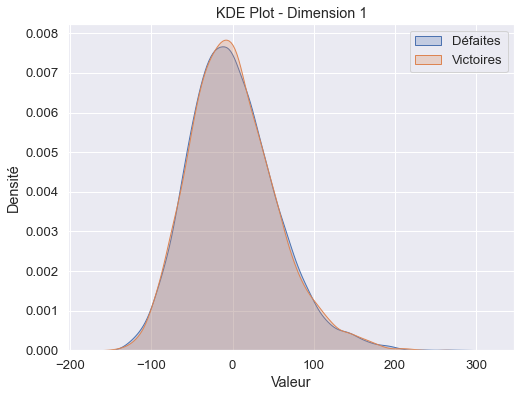

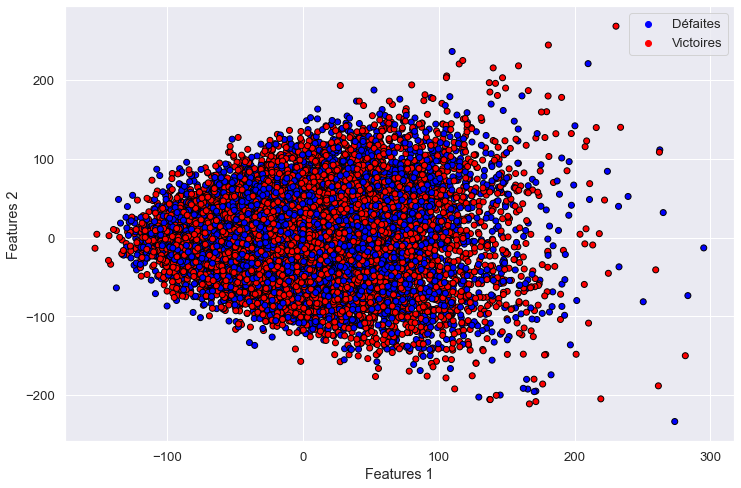

In [67]:
# Visualisationd des données en 1, 2, et 3 dimension(s)
peo.plot_1d(features, target)
peo.plot_2d(features, target)
# peo.plot_3d(features, target)

,Home_pts_mode,Home_pts_mean,Home_pts_std,Home_pts_var,Home_pts_q25,Home_pts_q75,Home_pts_iqr,Home_pts_median,Home_pts_min,Home_pts_max,...,Away_reb_iqr,Away_reb_median,Away_reb_min,Away_reb_max,Away_reb_skw,Away_reb_kur,Away_wr_mode,Away_wr_mean,Away_wr_std,Away_wr_var
0,73.0,85.15,10.529532,110.871053,76.50,91.50,15.00,84.5,70.0,105.0,...,10.75,4.0,-19.0,13.0,-0.856218,1.227661,0.0,0.50,0.512989,0.263158
1,86.0,94.80,7.134792,50.905263,89.75,99.25,9.50,94.5,82.0,107.0,...,15.75,1.5,-19.0,10.0,-0.490177,-0.990095,0.0,0.35,0.489360,0.239474
2,82.0,88.60,13.566212,184.042105,82.00,98.00,16.00,90.5,58.0,109.0,...,11.00,4.0,-19.0,13.0,-1.093317,1.793057,0.0,0.50,0.512989,0.263158
3,89.0,92.85,7.400391,54.765789,89.00,98.25,9.25,91.5,78.0,110.0,...,7.75,-2.0,-19.0,10.0,-0.527223,0.890645,0.0,0.40,0.502625,0.252632
4,83.0,91.00,10.602879,112.421053,83.00,95.00,12.00,89.5,72.0,115.0,...,7.50,-2.5,-16.0,12.0,0.216707,0.128035,1.0,0.60,0.502625,0.252632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15467,106.0,108.40,7.735088,59.831579,104.75,114.25,9.50,108.5,93.0,120.0,...,9.25,-4.0,-18.0,15.0,0.432504,0.384842,0.0,0.45,0.510418,0.260526
15468,94.0,102.80,11.865918,140.800000,94.00,111.50,17.50,100.5,87.0,131.0,...,11.75,2.0,-15.0,15.0,-0.451213,-0.650026,1.0,0.60,0.502625,0.252632
15469,98.0,103.25,11.575269,133.986842,95.25,112.00,16.75,106.0,77.0,118.0,...,11.75,5.5,-14.0,18.0,-0.355206,-0.682619,1.0,0.75,0.444262,0.197368
15470,93.0,97.60,9.411080,88.568421,92.50,102.25,9.75,95.0,81.0,122.0,...,12.00,3.0,-15.0,26.0,0.405542,1.325940,0.0,0.45,0.510418,0.260526


0        0
1        0
2        0
3        0
4        0
        ..
15467    1
15468    1
15469    1
15470    1
15471    1
Name: result, Length: 15472, dtype: int64

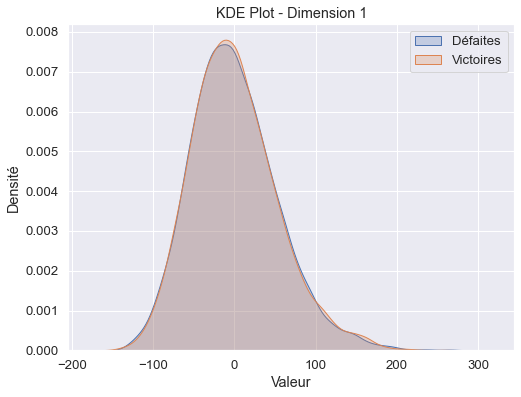

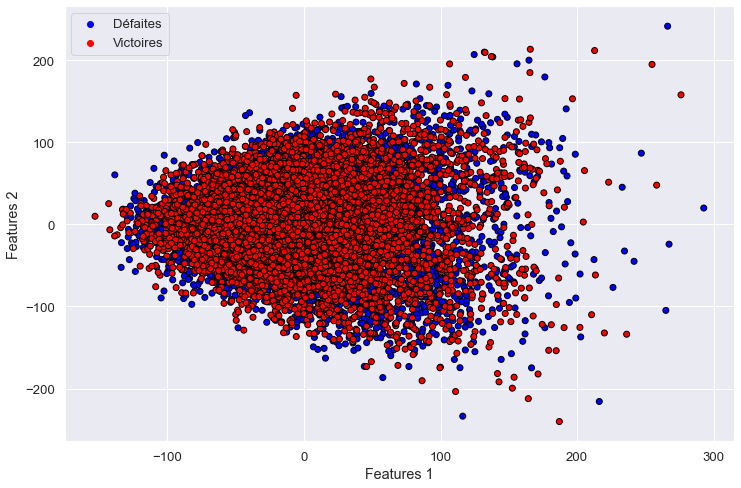

In [66]:
# Retirer les ouliers et équilibrage des classes
new_features, new_target = pp.preprocess_data(features, target, random_state=random_state)
display(new_features)
display(new_target)
peo.plot_1d(new_features, new_target)
peo.plot_2d(new_features, new_target)
# peo.plot_3d(new_features, new_target)

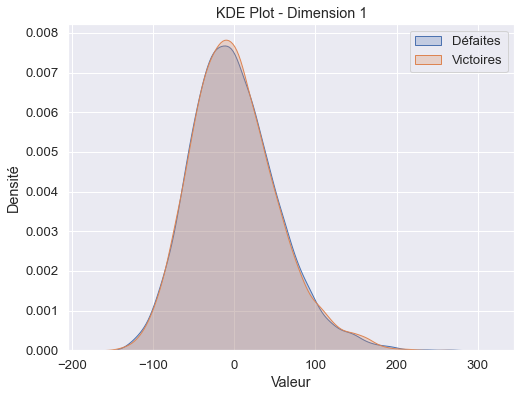

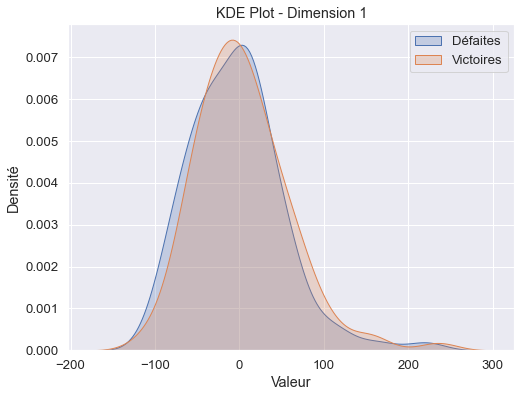

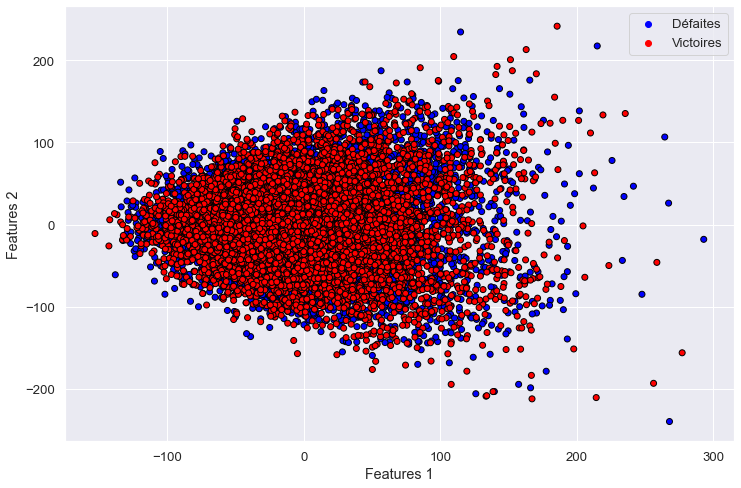

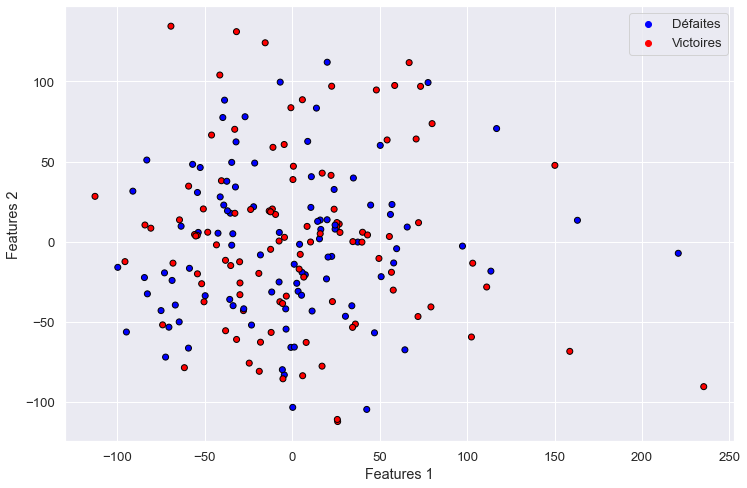

In [63]:
# Splitting des données en train et test set (utilisation de la méthode SPlit pour la séparation des données)
X, x_test, y, y_test = pp.train_test_split_twin(new_features, new_target, test_size=200)
peo.plot_1d(X, y)
peo.plot_1d(x_test, y_test)
peo.plot_2d(X, y)
peo.plot_2d(x_test, y_test)

In [34]:
# Features augmentation pour avoir de nouvelles variables, potentiellement utiles
poly = PolynomialFeatures(degree=2).fit(X)
X_poly, x_test_poly = poly.transform(X), poly.transform(x_test)

# Utilisaiton d'une Random Forest pour la selection des variables
estimator = random_forest_model = RandomForestClassifier(
    n_estimators=300,  # Le nombre d'arbres dans la forêt
    criterion="gini",  # La fonction de mesure de la qualité de la division ('gini' ou 'entropy')
    max_depth=None,  # La profondeur maximale des arbres (None signifie aucune limite)
    min_samples_split=2,  # Nombre minimum d'échantillons requis pour diviser un nœud interne
    min_samples_leaf=1,  # Nombre minimum d'échantillons requis pour être une feuille
    max_features='auto',  # Le nombre de caractéristiques à considérer pour la meilleure division ('auto', 'sqrt', 'log2', None, int, float)
    bootstrap=True,  # Si les échantillons de démarrage sont utilisés pour construire des arbres
    random_state=random_state,  # Graine aléatoire pour la reproductibilité
    n_jobs=-1,  # Le nombre de cœurs CPU à utiliser pour l'entraînement (-1 signifie tous les cœurs)
    class_weight="balanced",  # Poids donnés aux classes (dict ou 'balanced')
    verbose=0,  # Contrôle la verbosité lors de l'apprentissage (0 pour aucun message, 1 pour les messages minimum, 2 pour plus de détails)
    warm_start=False,  # Si de nouveaux arbres doivent être ajoutés à la forêt existante
)

# Selection des meilleures variables
selector = SelectFromModel(estimator=estimator, threshold="2*mean").fit(X_poly, y)
X_trans, x_test_trans = pd.DataFrame(selector.transform(X_poly)), pd.DataFrame(selector.transform(x_test_poly))

,0,1,2,3,4,5,6,7,8,9,...,645,646,647,648,649,650,651,652,653,654
0,0.43700,0.45,0.510418,38.70,30.10,0.00,42.660,0.00,33.1800,0.000000,...,0.059868,0.00,0.000000,-0.00,-0.0,0.0,3.50,0.0,0.1225,0.171276
1,0.43335,0.25,0.444262,20.50,41.00,0.00,22.150,0.00,44.3000,0.000000,...,0.072368,0.00,0.000000,-0.00,-0.0,0.0,6.50,0.0,0.2500,0.256495
2,0.45205,0.60,0.502625,53.40,35.60,92.85,55.710,0.00,37.1400,7.400391,...,0.092968,0.00,0.000000,-0.00,-0.0,0.0,4.00,0.0,0.1600,0.201050
3,0.43065,0.25,0.444262,20.75,49.80,0.00,22.750,91.00,54.6000,0.000000,...,0.072253,0.50,7.116327,-6.25,-16.0,12.0,7.20,1.0,0.3600,0.301575
4,0.42720,0.70,0.470162,56.00,40.00,91.50,64.050,0.00,45.7500,8.178920,...,0.090263,0.00,0.000000,-0.00,-0.0,0.0,4.50,0.0,0.2500,0.256495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15266,0.47790,0.85,0.366348,90.10,47.70,108.40,92.140,0.00,48.7800,7.735088,...,0.081545,0.00,0.000000,-0.00,-0.0,0.0,6.75,0.0,0.2025,0.229688
15267,0.46010,0.65,0.489360,61.10,56.40,102.80,66.820,102.80,61.6800,11.865918,...,0.084126,0.50,8.738300,-4.75,-15.0,15.0,9.00,1.0,0.3600,0.301575
15268,0.48295,0.70,0.470162,68.60,73.50,103.25,72.275,103.25,77.4375,11.575269,...,0.064046,0.65,9.157108,-3.25,-14.0,18.0,13.50,1.0,0.5625,0.333196
15269,0.44370,0.40,0.502625,37.20,41.85,0.00,39.040,0.00,43.9200,0.000000,...,0.100042,0.00,0.000000,-0.00,-0.0,0.0,11.70,0.0,0.2025,0.229688


,0,1,2,3,4,5,6,7,8,9,...,645,646,647,648,649,650,651,652,653,654
0,0.40025,0.30,0.470162,21.90,36.50,0.00,25.5450,0.00,42.5750,0.000000,...,0.081053,0.000,0.000000,-0.00,-0.0,0.0,6.50,0.0,0.2500,0.256495
1,0.42705,0.50,0.512989,36.00,54.00,0.00,45.9250,91.85,68.8875,0.000000,...,0.047467,0.556,8.140219,-1.25,-8.0,23.0,17.25,1.0,0.5625,0.333196
2,0.43165,0.55,0.510418,45.65,33.20,90.05,49.5275,0.00,36.0200,10.195329,...,0.087158,0.000,0.000000,-0.00,-0.0,0.0,5.20,0.0,0.1600,0.201050
3,0.46060,0.60,0.502625,58.80,63.70,94.60,56.7600,94.60,61.4900,9.885662,...,0.079745,0.571,6.942432,0.00,-16.0,14.0,9.10,1.0,0.4225,0.318084
4,0.45460,0.65,0.489360,55.90,55.90,98.00,63.7000,98.00,63.7000,13.661317,...,0.093634,0.556,9.458497,-8.25,-14.0,18.0,11.70,1.0,0.4225,0.318084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,0.42285,0.10,0.307794,10.70,53.50,0.00,10.4850,0.00,52.4250,0.000000,...,0.091974,0.000,0.000000,-0.00,-0.0,0.0,11.50,0.0,0.2500,0.256495
197,0.46725,0.65,0.489360,61.10,28.20,100.30,65.1950,0.00,30.0900,12.481987,...,0.070847,0.000,0.000000,0.00,-0.0,0.0,7.80,0.0,0.0900,0.141049
198,0.47305,0.35,0.489360,35.35,35.35,0.00,33.9850,0.00,33.9850,0.000000,...,0.085013,0.000,0.000000,-0.00,-0.0,0.0,4.20,0.0,0.1225,0.171276
199,0.45625,0.55,0.510418,53.90,68.60,102.70,56.4850,102.70,71.8900,12.105240,...,0.055263,0.563,8.347076,-9.50,-24.0,11.0,7.70,1.0,0.4900,0.329114


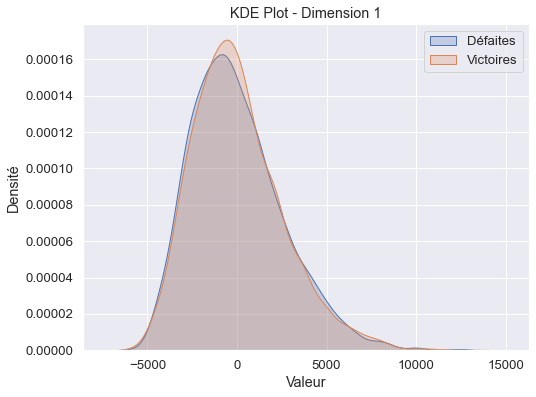

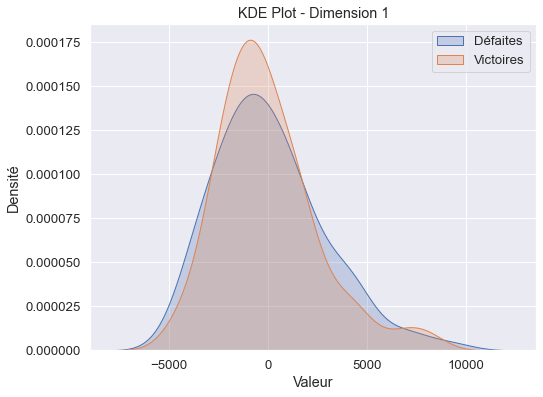

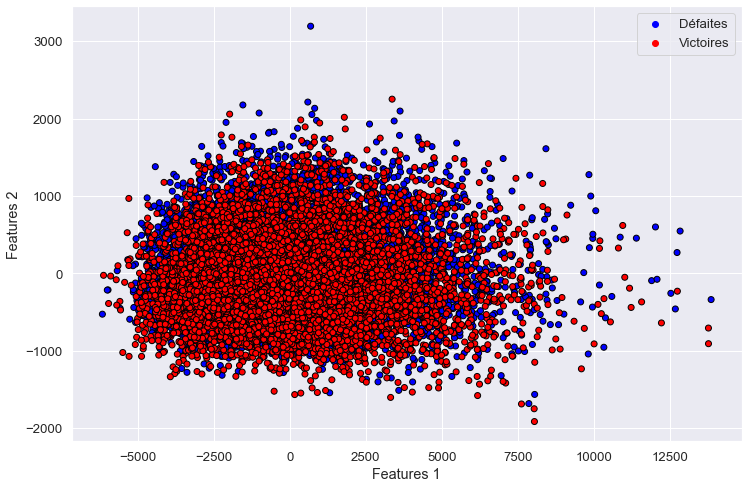

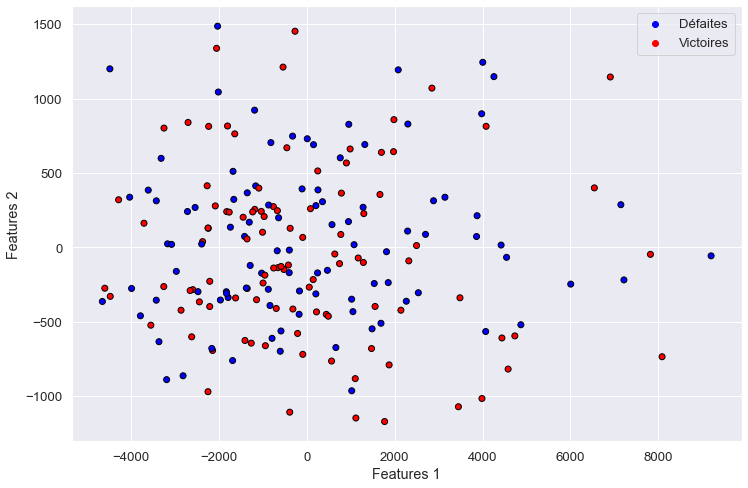

In [35]:
# Vérifications
display(X_trans)
display(x_test_trans)
peo.plot_kde_1d_with_labels(X_trans, y)
peo.plot_kde_1d_with_labels(x_test_trans, y_test)
peo.plot_dimension_reduction(X_trans, y)
peo.plot_dimension_reduction(x_test_trans, y_test)

# Entraînement + Résultats

Rapport de classification pour Régression Logistique :



c:\Users\Utilisateur\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.67      0.69      0.68        98
           1       0.70      0.68      0.69       103

    accuracy                           0.69       201
   macro avg       0.69      0.69      0.69       201
weighted avg       0.69      0.69      0.69       201



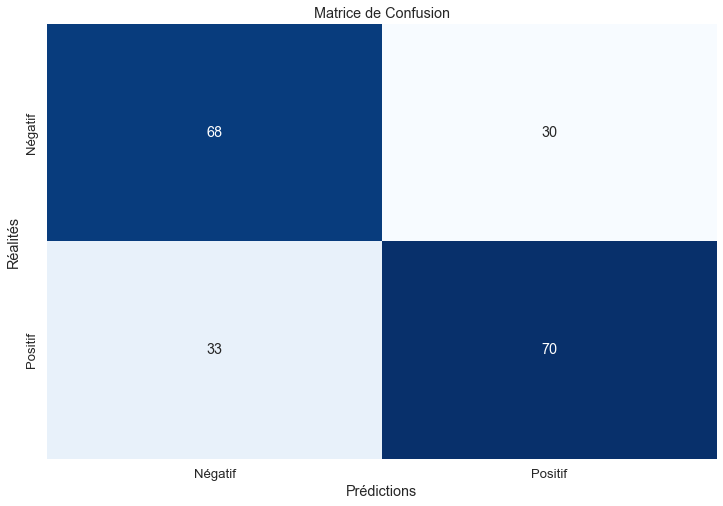

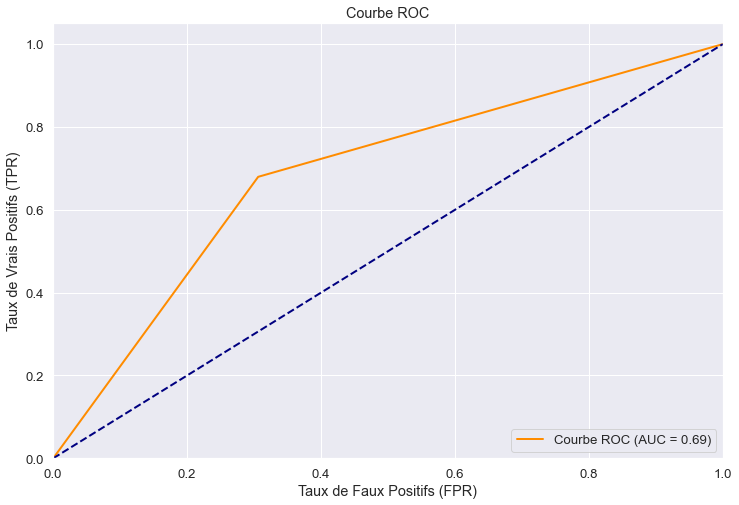

Rapport de classification pour SVM (Machine à Vecteurs de Support) :

              precision    recall  f1-score   support

           0       0.58      0.66      0.62        98
           1       0.63      0.54      0.58       103

    accuracy                           0.60       201
   macro avg       0.60      0.60      0.60       201
weighted avg       0.61      0.60      0.60       201



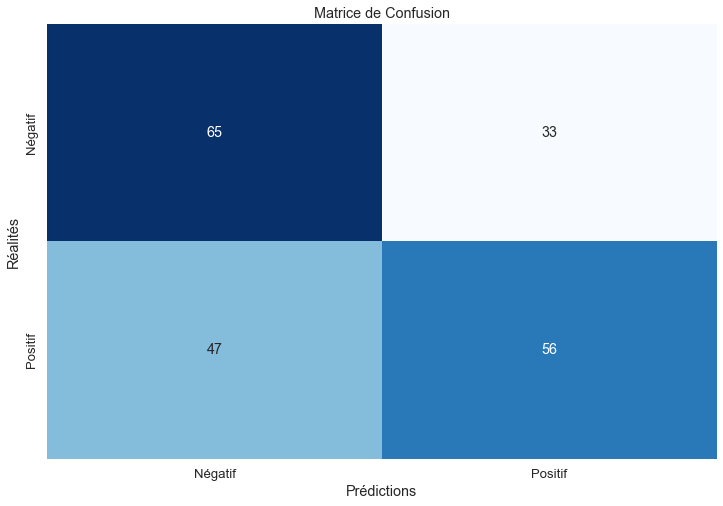

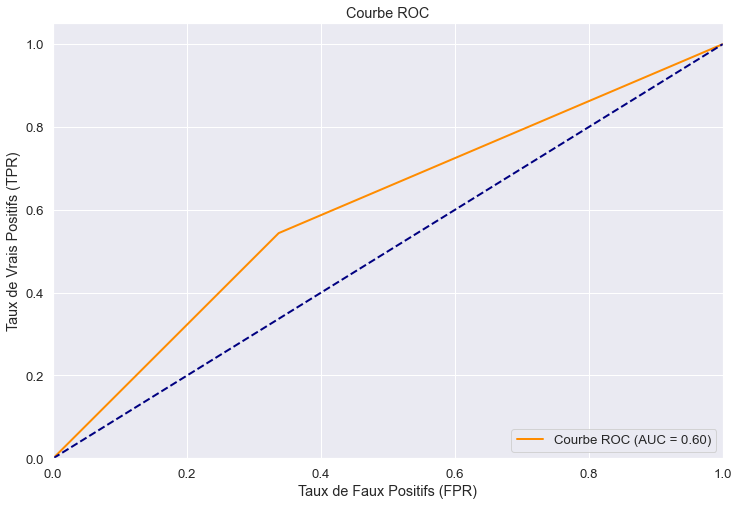

Rapport de classification pour k-Plus Proches Voisins :

              precision    recall  f1-score   support

           0       0.57      0.59      0.58        98
           1       0.60      0.57      0.58       103

    accuracy                           0.58       201
   macro avg       0.58      0.58      0.58       201
weighted avg       0.58      0.58      0.58       201



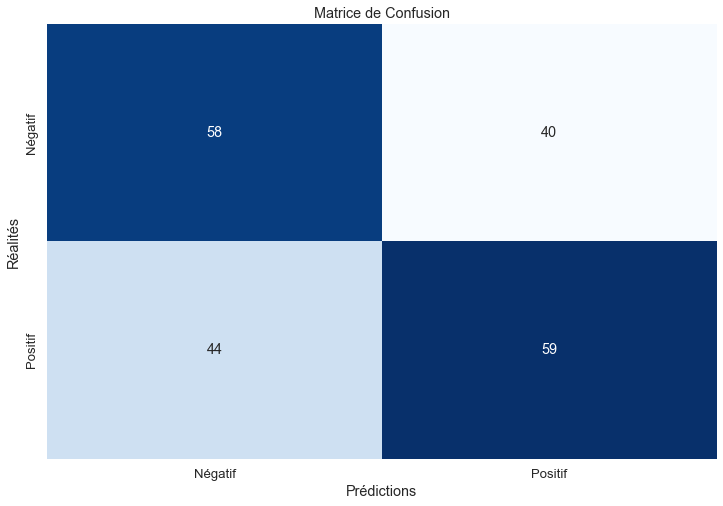

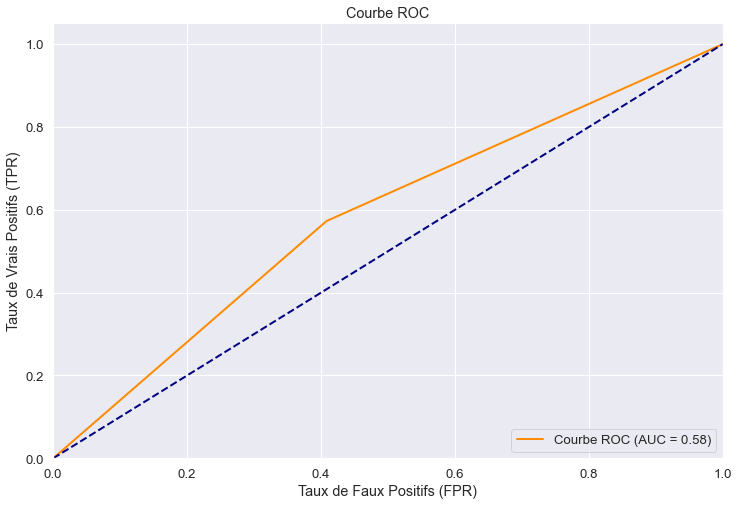

Rapport de classification pour LDA :

              precision    recall  f1-score   support

           0       0.63      0.66      0.65        98
           1       0.66      0.63      0.65       103

    accuracy                           0.65       201
   macro avg       0.65      0.65      0.65       201
weighted avg       0.65      0.65      0.65       201



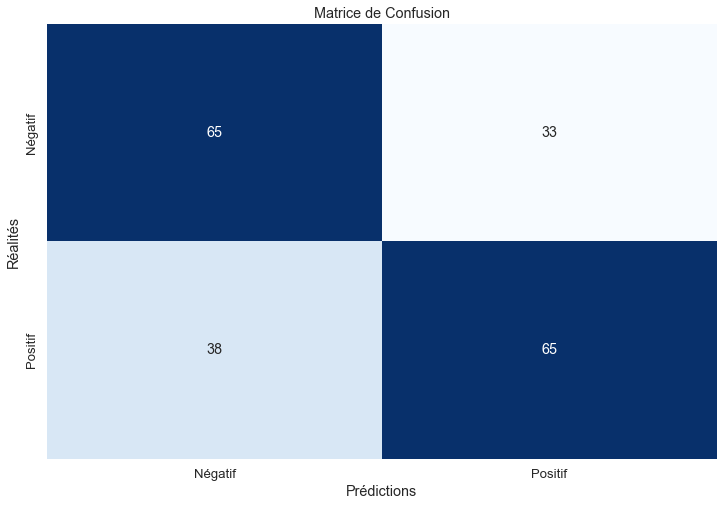

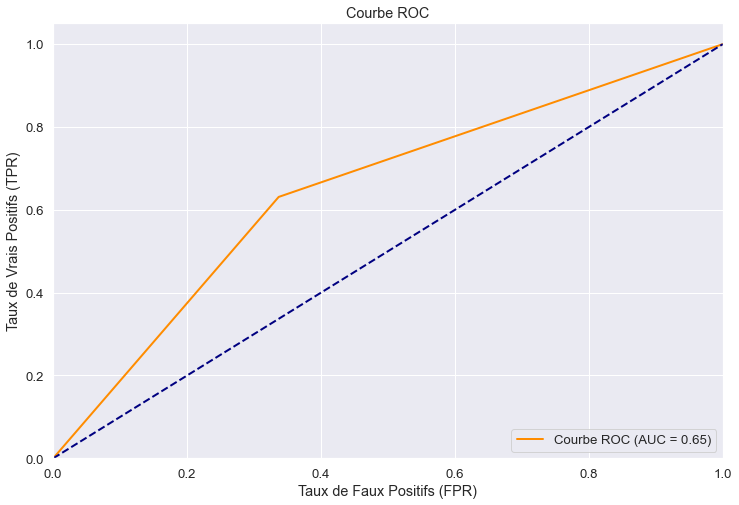

Rapport de classification pour KDA :



c:\Users\Utilisateur\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


              precision    recall  f1-score   support

           0       0.66      0.73      0.70        98
           1       0.72      0.64      0.68       103

    accuracy                           0.69       201
   macro avg       0.69      0.69      0.69       201
weighted avg       0.69      0.69      0.69       201



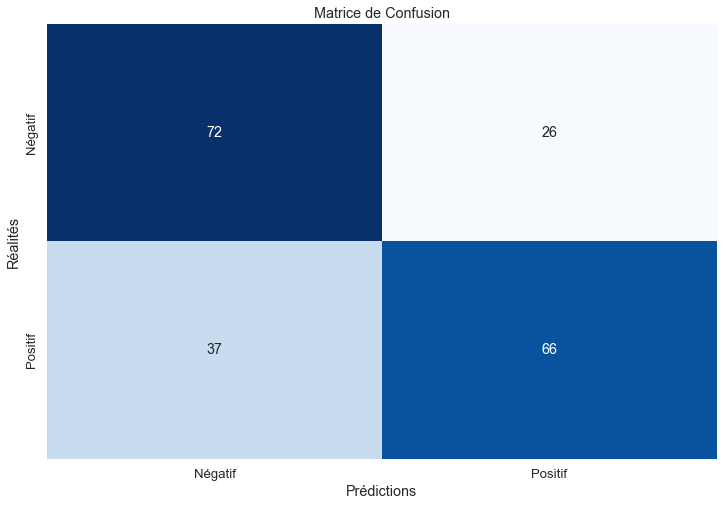

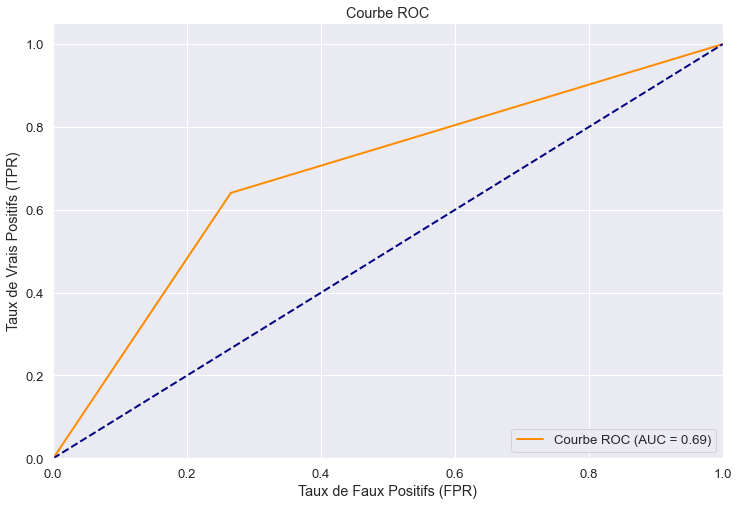

Rapport de classification pour Naive Bayes (Bernoulli) :

              precision    recall  f1-score   support

           0       0.77      0.42      0.54        98
           1       0.61      0.88      0.73       103

    accuracy                           0.66       201
   macro avg       0.69      0.65      0.63       201
weighted avg       0.69      0.66      0.64       201



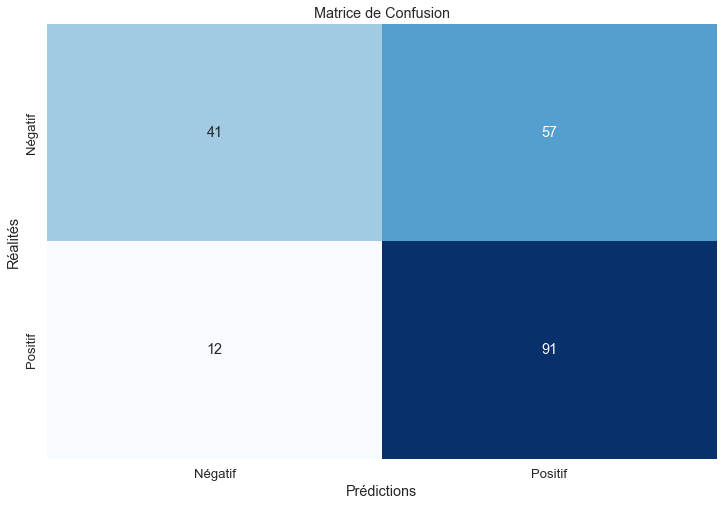

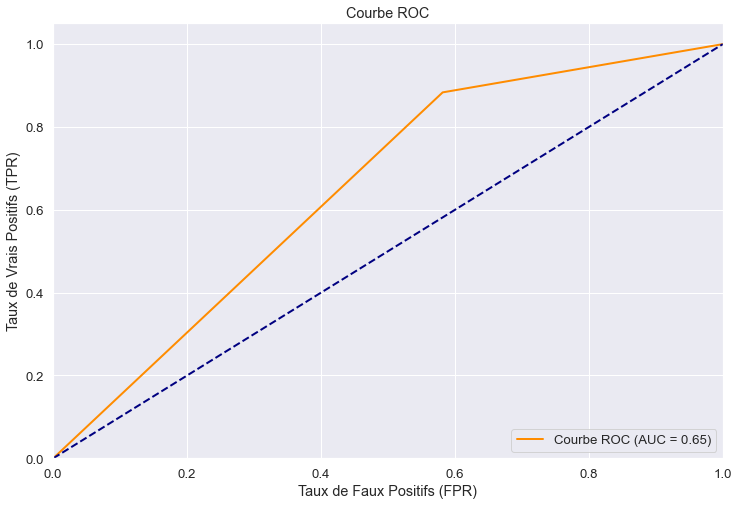

Rapport de classification pour Naive Bayes (Gaussien) :

              precision    recall  f1-score   support

           0       0.68      0.71      0.70        98
           1       0.71      0.68      0.70       103

    accuracy                           0.70       201
   macro avg       0.70      0.70      0.70       201
weighted avg       0.70      0.70      0.70       201



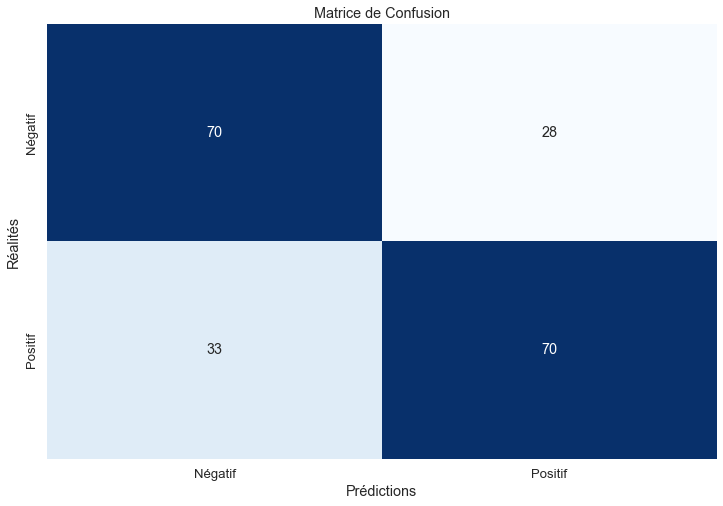

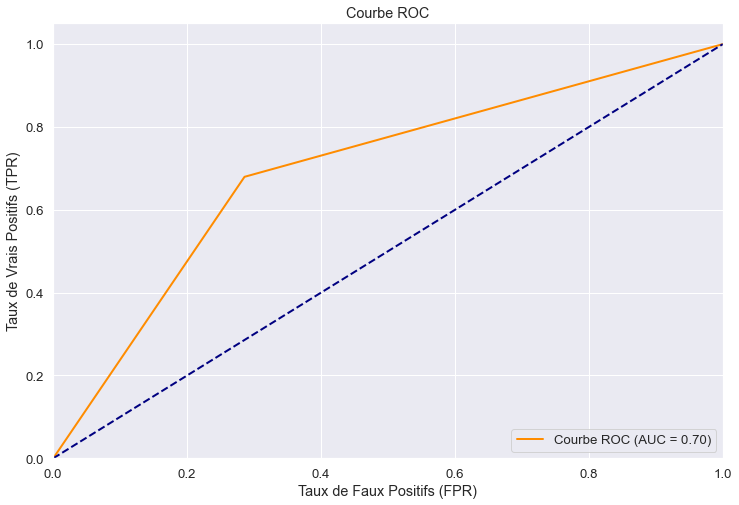

Rapport de classification pour Forêt Aléatoire :

              precision    recall  f1-score   support

           0       0.66      0.68      0.67        98
           1       0.69      0.66      0.67       103

    accuracy                           0.67       201
   macro avg       0.67      0.67      0.67       201
weighted avg       0.67      0.67      0.67       201



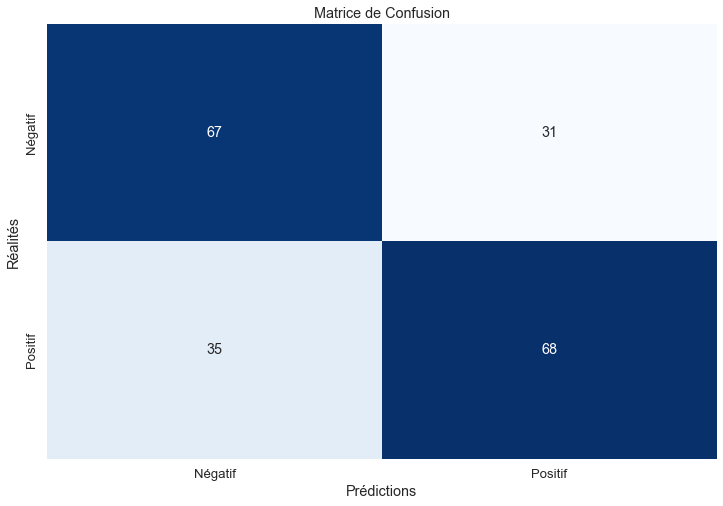

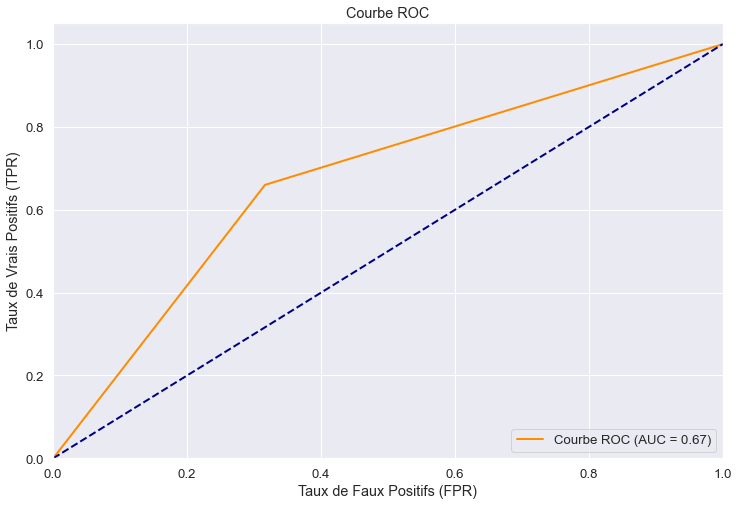

Rapport de classification pour Gradient Boosting :

              precision    recall  f1-score   support

           0       0.66      0.66      0.66        98
           1       0.68      0.68      0.68       103

    accuracy                           0.67       201
   macro avg       0.67      0.67      0.67       201
weighted avg       0.67      0.67      0.67       201



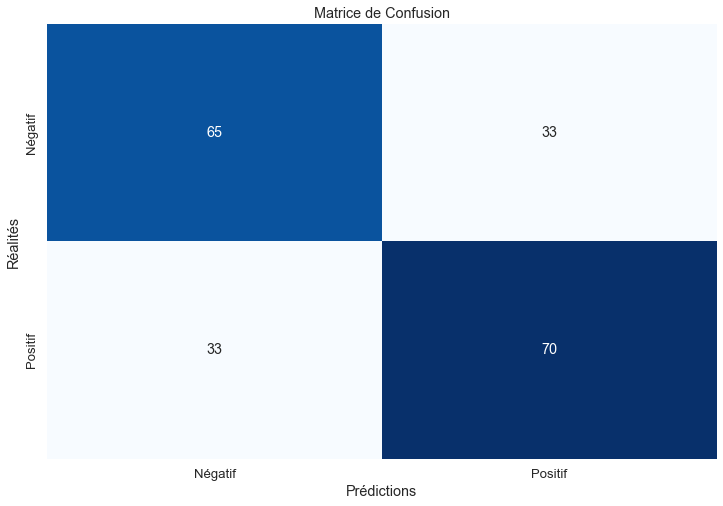

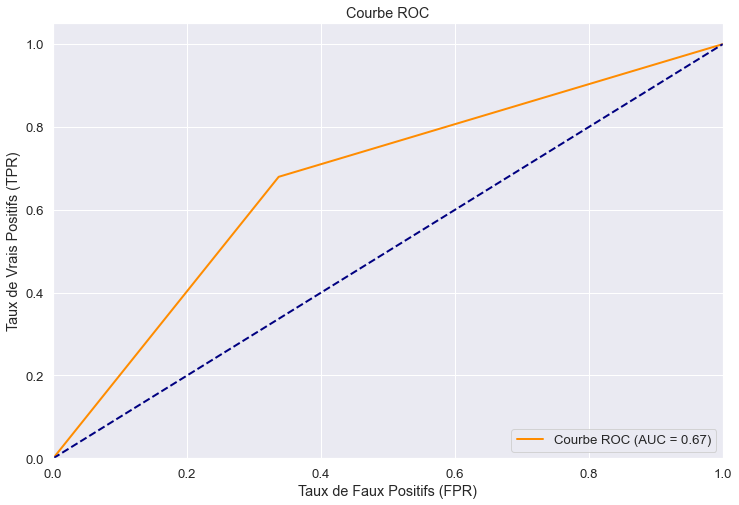

In [36]:
# Dictionnaires de modèles à tester
models = {
    'Régression Logistique': LogisticRegression(max_iter=1000, class_weight="balanced", random_state=random_state),
    'SVM (Machine à Vecteurs de Support)': SVC(class_weight="balanced", random_state=random_state),
    'k-Plus Proches Voisins': KNeighborsClassifier(),
    'LDA' : LinearDiscriminantAnalysis(),
    'KDA' : QuadraticDiscriminantAnalysis(),
    'Naive Bayes (Bernoulli)': BernoulliNB(),
    'Naive Bayes (Gaussien)': GaussianNB(),
    'Forêt Aléatoire': RandomForestClassifier(class_weight="balanced", random_state=random_state),
    'Gradient Boosting': GradientBoostingClassifier(random_state=random_state),
}

peo.evaluate_models(models=models, X_train=X_trans, y_train=y, X_test=x_test_trans, y_test=y_test)

Rapport de classification pour VotingClassifieur :



              precision    recall  f1-score   support

           0       0.69      0.69      0.69        98
           1       0.71      0.70      0.70       103

    accuracy                           0.70       201
   macro avg       0.70      0.70      0.70       201
weighted avg       0.70      0.70      0.70       201



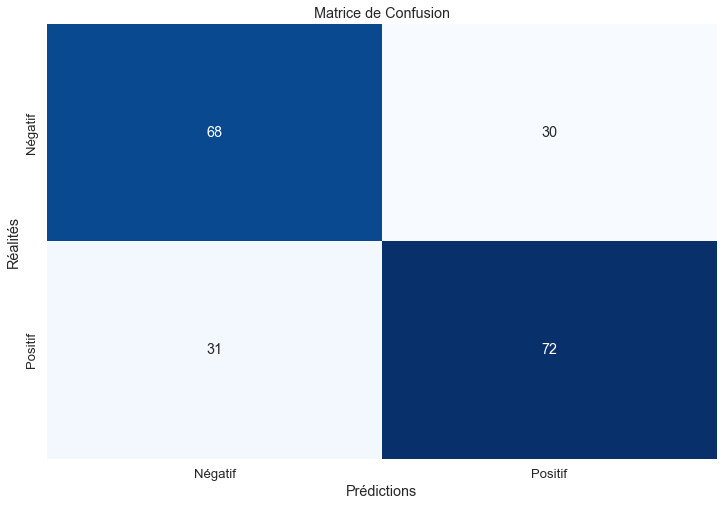

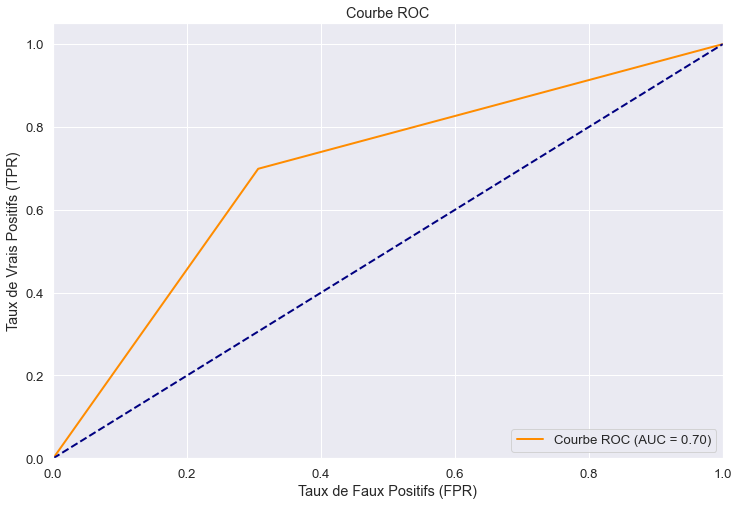

In [37]:
# Définition d'un votingClassifieur, pour rendre les prédictions plus stables
base_models = [
    ('lgc', LogisticRegression(max_iter=1000, class_weight="balanced", random_state=random_state)),
    ('Kda', QuadraticDiscriminantAnalysis()),
    ('gnb', GaussianNB()),
    ('rfc', RandomForestClassifier(class_weight="balanced", random_state=random_state, n_jobs=-1)),
    ('gbc', GradientBoostingClassifier(random_state=random_state))
]

voting_model = {"VotingClassifieur" : VotingClassifier(estimators=base_models, n_jobs=-1, voting="soft")}

peo.evaluate_models(voting_model, X, y, x_test, y_test)